In [1]:
import numpy as np
import pandas as pd

In [8]:
Tetrapos_atomic=pd.read_csv("C:\\Users\\HP\\Desktop\\SEM#3\\MLBA\\tetrapositive_atomic.csv")
Tetraneg_atomic=pd.read_csv("C:\\Users\\HP\\Desktop\\SEM#3\\MLBA\\tetranegative_atomicacid.csv")
Tetrapos_atomic['Label'] = 1
Tetraneg_atomic['Label'] = 0

In [9]:
Tetra_dataset_atomic=Tetraneg_atomic.append(Tetrapos_atomic, ignore_index = True)

In [10]:
Names=Tetra_dataset_atomic['Names']
Class=Tetra_dataset_atomic['Label']
Tetra_data_atomic=Tetra_dataset_atomic.drop(['Names','Label'],axis=1)

In [11]:
from sklearn.model_selection import train_test_split
def splitdataset(fulldata,fulldatalabel,k):
    X_train, X_test, y_train, y_test = train_test_split(fulldata,fulldatalabel,test_size=k,random_state=100)
    return X_train,X_test,y_train,y_test

In [13]:
X_train,X_test,y_train,y_test=splitdataset(Tetra_data_atomic,Class,0.30) # HOLD OUT SET

In [17]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
param_grid = {
    'bootstrap': [True],
    'max_depth': [5,10,20],
    'max_features': [5],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200]
}
# Create a based model
rf = RandomForestClassifier()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 5, n_jobs = -1, verbose = 2)

# Fit the grid search to the data
grid_search.fit(X_train,y_train)
print(grid_search.best_params_)
best_grid = grid_search.best_estimator_



Fitting 5 folds for each of 54 candidates, totalling 270 fits


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   29.3s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 270 out of 270 | elapsed:  2.5min finished


{'bootstrap': True, 'min_samples_leaf': 4, 'n_estimators': 100, 'min_samples_split': 10, 'max_features': 5, 'max_depth': 20}


In [21]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
rf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=20, max_features=5, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=4, min_samples_split=10,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
rf.fit(X_train,y_train)
y_pred=rf.predict(X_test)
print(accuracy_score(y_pred,y_test))
print(classification_report(y_pred,y_test))

0.5978260869565217
             precision    recall  f1-score   support

          0       0.65      0.53      0.58        49
          1       0.56      0.67      0.61        43

avg / total       0.61      0.60      0.60        92



In [22]:
from sklearn import svm, grid_search
def svc_param_selection(X, y, nfolds):
    Cs = [0.001, 0.01, 0.1, 1, 10]
    gammas = [0.001, 0.01, 0.1, 1]
    kernels=['rbf']
    param_grid = {'C': Cs, 'gamma' : gammas,'kernel':kernels}
    grid_search = GridSearchCV(svm.SVC(), param_grid, cv=nfolds)
    grid_search.fit(X, y)
    grid_search.best_params_
    return grid_search.best_params_

C:\ProgramData\Anaconda2\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [23]:
svc_param_selection(X_train,y_train,5)

{'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}

In [24]:
from sklearn.model_selection import LeaveOneOut 
def LOOV(traindata,trainlabel,model): 
    X=traindata
    y=trainlabel
    loo = LeaveOneOut()
    loo.get_n_splits(X)
    trainaccuracy=[]
    pred_prob=[]
    predlabel=[]
    truelabel=[]
    for train_index, test_index in loo.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        X_train=pd.DataFrame(X_train)
        X_test=pd.DataFrame(X_test)
        y_train=pd.Series(y_train)
        y_test=pd.Series(y_test)       
        model.fit(X_train,y_train)
        y_pred=model.predict(X_test)
        y_pred_train=model.predict(X_train)
        trainaccuracy.append(accuracy_score(y_train, y_pred_train))
        prob=model.predict_proba(X_test)
        pred_prob.append(prob[0][1])
        predlabel.append(y_pred[0])
        truelabel.append(y_test.iloc[0])
    print("Average Test Accuracy :",accuracy_score(truelabel,predlabel))
    print("Average Train Accuracy :",sum(trainaccuracy)/len(trainaccuracy))
    return truelabel,predlabel,pred_prob
   

In [25]:
X_train=X_train.reset_index(drop=True)
y_train=y_train.reset_index(drop=True)

In [31]:
from sklearn import metrics
import matplotlib.pyplot as plt
model=svm.SVC(C=1, gamma=0.001,kernel='rbf',probability=True)

truelabel,predlabel,pred_prob=LOOV(X_train,y_train,model)
auc = metrics.roc_auc_score(truelabel, pred_prob)
print(auc)


('Average Test Accuracy :', 0.6214953271028038)
('Average Train Accuracy :', 0.6317844763283748)
0.6806273547708754


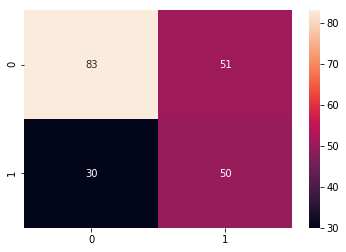

In [32]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
cf=confusion_matrix(predlabel,truelabel)
ax = sns.heatmap(cf, annot=True, fmt="d")

# SVM HOLD OUT

In [ ]:
model=svm.SVC(C=1, gamma=0.1,kernel='rbf',probability=True)
model.fit(X_train,y_train)
y_pred=model.predict(X_test)
pred_prob=model.predict_proba(X_test)
auc = metrics.roc_auc_score(y_test,pred_prob[:,1])
fpr, tpr, _ = metrics.roc_curve(y_test,pred_prob[:,1])
plt.plot(fpr,tpr,label="auc="+str(auc))
plt.legend(loc=4)
plt.show()
print(classification_report(y_pred,y_test))

# Random Forest Leave One Out

In [40]:
model = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features=5, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=4, min_samples_split=10,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
truelabel,predlabel,pred_prob=LOOV(X_train,y_train,model)
print(classification_report(predlabel,truelabel))
auc = metrics.roc_auc_score(truelabel, pred_prob)

('Average Test Accuracy :', 0.6635514018691588)
('Average Train Accuracy :', 0.8061954280198325)
             precision    recall  f1-score   support

          0       0.65      0.69      0.67       107
          1       0.67      0.64      0.65       107

avg / total       0.66      0.66      0.66       214



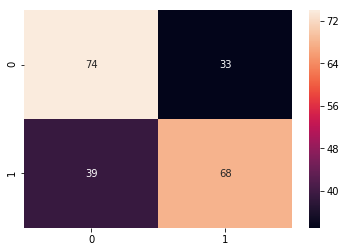

In [41]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
cf=confusion_matrix(predlabel,truelabel)
ax = sns.heatmap(cf, annot=True, fmt="d")

# random Forest holdout

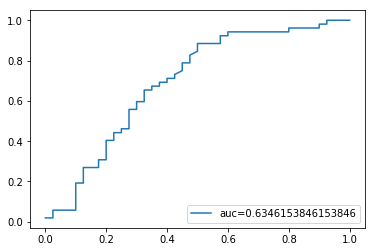

             precision    recall  f1-score   support

          0       0.60      0.52      0.56        46
          1       0.58      0.65      0.61        46

avg / total       0.59      0.59      0.59        92



In [42]:
model = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features=5, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=4, min_samples_split=10,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
model.fit(X_train,y_train)
y_pred=model.predict(X_test)
pred_prob=model.predict_proba(X_test)
auc = metrics.roc_auc_score(y_test,pred_prob[:,1])
plt.plot(fpr,tpr,label="auc="+str(auc))
plt.legend(loc=4)
plt.show()
print(classification_report(y_pred,y_test))

In [43]:
# Logistic Regression LOOV

('Average Test Accuracy :', 0.6214953271028038)
('Average Train Accuracy :', 0.6623447852222385)


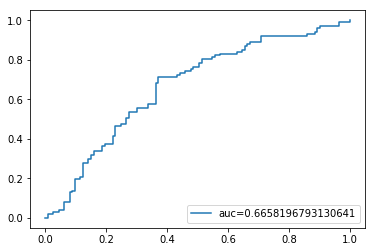

In [44]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
import matplotlib.pyplot as plt
model=LogisticRegression(random_state=10, solver='liblinear',penalty='l1',max_iter=100)
truelabel,predlabel,pred_prob=LOOV(X_train,y_train,model)
fpr, tpr, _ = metrics.roc_curve(truelabel,pred_prob)
auc = metrics.roc_auc_score(truelabel, pred_prob)
plt.plot(fpr,tpr,label="auc="+str(auc))
plt.legend(loc=4)
plt.show()

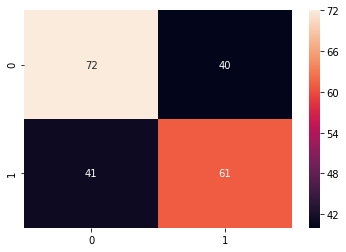

In [45]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
cf=confusion_matrix(predlabel,truelabel)
ax = sns.heatmap(cf, annot=True, fmt="d")

In [46]:
print(classification_report(predlabel,truelabel))


             precision    recall  f1-score   support

          0       0.64      0.64      0.64       112
          1       0.60      0.60      0.60       102

avg / total       0.62      0.62      0.62       214



# LOGISTIC Regression on HOLD OUT SET

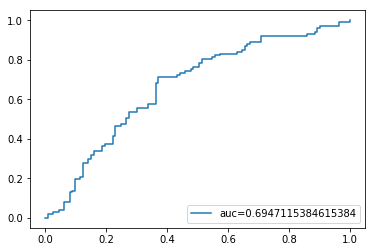

             precision    recall  f1-score   support

          0       0.65      0.57      0.60        46
          1       0.62      0.70      0.65        46

avg / total       0.63      0.63      0.63        92



In [50]:
model=LogisticRegression(random_state=10, solver='liblinear',penalty='l1',max_iter=100)
model.fit(X_train,y_train)
y_pred=model.predict(X_test)
pred_prob=model.predict_proba(X_test)
auc = metrics.roc_auc_score(y_test,pred_prob[:,1])
plt.plot(fpr,tpr,label="auc="+str(auc))
plt.legend(loc=4)
plt.show()
print(classification_report(y_pred,y_test))

# KNeighborsClassifier

('Average Test Accuracy :', 0.5934579439252337)
('Average Train Accuracy :', 0.7475319204949323)


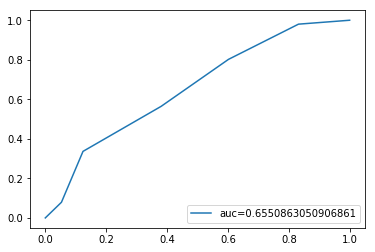

In [51]:
from sklearn.neighbors import KNeighborsClassifier
model = KNeighborsClassifier(n_neighbors=5)
truelabel,predlabel,pred_prob=LOOV(X_train,y_train,model)
fpr, tpr, _ = metrics.roc_curve(truelabel,pred_prob)
auc = metrics.roc_auc_score(truelabel, pred_prob)
plt.plot(fpr,tpr,label="auc="+str(auc))
plt.legend(loc=4)
plt.show()

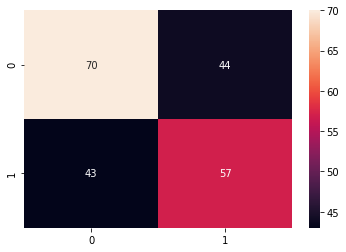

In [52]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
cf=confusion_matrix(predlabel,truelabel)
ax = sns.heatmap(cf, annot=True, fmt="d")

In [53]:
print(classification_report(predlabel,truelabel))

             precision    recall  f1-score   support

          0       0.62      0.61      0.62       114
          1       0.56      0.57      0.57       100

avg / total       0.59      0.59      0.59       214



# KNN on Holdout set

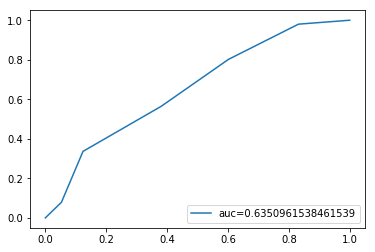

             precision    recall  f1-score   support

          0       0.53      0.57      0.55        37
          1       0.69      0.65      0.67        55

avg / total       0.63      0.62      0.62        92



In [54]:
model=KNeighborsClassifier(n_neighbors=5)
model.fit(X_train,y_train)
y_pred=model.predict(X_test)
pred_prob=model.predict_proba(X_test)
auc = metrics.roc_auc_score(y_test,pred_prob[:,1])
plt.plot(fpr,tpr,label="auc="+str(auc))
plt.legend(loc=4)
plt.show()
print(classification_report(y_pred,y_test))